<a href="https://colab.research.google.com/github/Samuela31/Deep-Learning-Laboratory/blob/main/DL_Lab_6_Image_Generation_(Style_Transfer).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.preprocessing.image as process_im
from PIL import Image
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
from tensorflow.python.keras import models
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import functools
import IPython.display

In [ ]:
content_path='a.png'
style_path = 'b.jpg'

**Define function to load images and return numpy array**

In [ ]:
def load_file(image_path):
    image =  Image.open(image_path)
    max_dim=512
    factor=max_dim/max(image.size)
    image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.ANTIALIAS)
    im_array = process_im.img_to_array(image)
    im_array = np.expand_dims(im_array,axis=0) #adding extra axis to the array as to generate a
                                               #batch of single image

    return im_array

**Define function to plot image**

In [ ]:
def show_im(img,title=None):
    img=np.squeeze(img,axis=0) #squeeze array to drop batch axis
    plt.imshow(np.uint8(img))
    if title is None:
        pass
    else:
        plt.title(title)
    plt.imshow(np.uint8(img))

**Plot Image**

In [ ]:
content = load_file(content_path)
style = load_file(style_path)

<ipython-input-4-eeebf87d3571>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.ANTIALIAS)


<ipython-input-4-eeebf87d3571>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.ANTIALIAS)


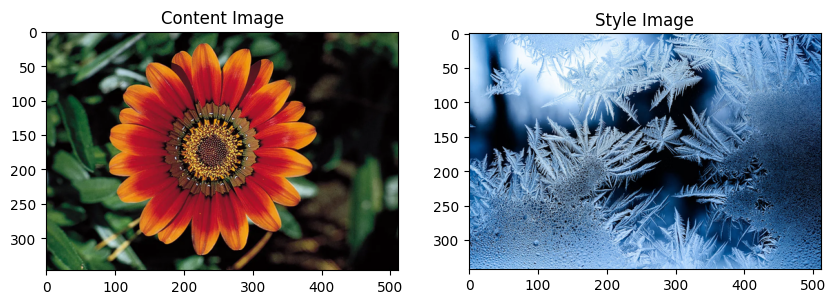

In [ ]:
plt.figure(figsize=(10,10))
content = load_file(content_path)
style = load_file(style_path)
plt.subplot(1,2,1)
show_im(content,'Content Image')
plt.subplot(1,2,2)
show_im(style,'Style Image')
plt.show()

**Define function to process image for input to vgg19 model**

In [ ]:
def img_preprocess(img_path):
    image=load_file(img_path)
    img=tf.keras.applications.vgg19.preprocess_input(image)
    return img

VGG networks are trained on image with each channel normalized by mean = [103.939, 116.779, 123.68]and with channels BGR.

In [ ]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3 #Input dimension must be [1, height, width, channel] or [height, width, channel]


  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1] # converting BGR to RGB channel

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [ ]:
im=img_preprocess(content_path)

<ipython-input-4-eeebf87d3571>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.ANTIALIAS)


**Get necessary layers from vgg19 model**

In [ ]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
number_content=len(content_layers)
number_style =len(style_layers)

**Define function to get vgg19 model with pretrained weights**

In [ ]:
def get_model():

    vgg=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
    vgg.trainable=False
    content_output=[vgg.get_layer(layer).output for layer in content_layers]
    style_output=[vgg.get_layer(layer).output for layer in style_layers]
    model_output= style_output+content_output
    return models.Model(vgg.input,model_output)

In [ ]:
model=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

**Model architecture**

In [ ]:
model=get_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 15,304,768
Trainable params: 0
Non-trainable params: 15,304,768
_________________________________________________________________


# **Loss Functions**

Neural style transfer is done by defining two loss functions that try to minimise the differences between a content image, a style image and a generated image. Take the base input image, the content image and the style image that needs to be matched and transform the base input image by minimizing the content and style distances (losses) with backpropagation, creating an image that matches the content of the content image and the style of the style image.

The content loss function ensures that the activations of the higher layers are similar between the content image and the generated image. The style loss function makes sure that the correlation of activations in all the layers are similar between the style image and the generated image.

**Define content loss**

Essentially content loss captures the root mean squared error between the activations produced by the generated image and the content image.

In [ ]:
def get_content_loss(noise,target):
    loss = tf.reduce_mean(tf.square(noise-target))
    return loss

**Define style loss**


The goal is to compute a style matrix for the generated image and the style image. Then the style loss is defined as the root mean square difference between the two style matrices. Style information is measured as the amount of correlation present between features maps in a given layer. Next, a loss is defined as the difference of correlation present between the feature maps computed by the generated image and the style image. The gram matrix is used to find the correlation between the feature maps of a convolution layer.

In [ ]:
def gram_matrix(tensor):
    channels=int(tensor.shape[-1])
    vector=tf.reshape(tensor,[-1,channels])
    n=tf.shape(vector)[0]
    gram_matrix=tf.matmul(vector,vector,transpose_a=True)
    return gram_matrix/tf.cast(n,tf.float32)

In [ ]:
def get_style_loss(noise,target):
    gram_noise=gram_matrix(noise)
    #gram_target=gram_matrix(target)
    loss=tf.reduce_mean(tf.square(target-gram_noise))
    return loss


In [ ]:
def get_features(model,content_path,style_path):
    content_img=img_preprocess(content_path)
    style_image=img_preprocess(style_path)

    content_output=model(content_img)
    style_output=model(style_image)

    content_feature = [layer[0] for layer in content_output[number_style:]]
    style_feature = [layer[0] for layer in style_output[:number_style]]
    return content_feature,style_feature


**Define function to compute total loss**

In [ ]:
def compute_loss(model, loss_weights,image, gram_style_features, content_features):
    style_weight,content_weight = loss_weights #style weight and content weight are user given parameters
                                               #that define what percentage of content and/or style will be preserved in the generated image

    output=model(image)
    content_loss=0
    style_loss=0

    noise_style_features = output[:number_style]
    noise_content_feature = output[number_style:]

    weight_per_layer = 1.0/float(number_style)
    for a,b in zip(gram_style_features,noise_style_features):
        style_loss+=weight_per_layer*get_style_loss(b[0],a)


    weight_per_layer =1.0/ float(number_content)
    for a,b in zip(noise_content_feature,content_features):
        content_loss+=weight_per_layer*get_content_loss(a[0],b)

    style_loss *= style_weight
    content_loss *= content_weight

    total_loss = content_loss + style_loss


    return total_loss,style_loss,content_loss

**Define function to calculate gradient**

In [ ]:
def compute_grads(dictionary):
    with tf.GradientTape() as tape:
        all_loss=compute_loss(**dictionary)

    total_loss=all_loss[0]
    return tape.gradient(total_loss,dictionary['image']),all_loss

In [ ]:
model=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')

In [ ]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
def run_style_transfer(content_path,style_path,epochs=500,content_weight=1e3, style_weight=1e-2):

    model=get_model()

    for layer in model.layers:
        layer.trainable = False

    content_feature,style_feature = get_features(model,content_path,style_path)
    style_gram_matrix=[gram_matrix(feature) for feature in style_feature]

    noise = img_preprocess(content_path)
    noise=tf.Variable(noise,dtype=tf.float32)

    optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

    best_loss,best_img=float('inf'),None

    loss_weights = (style_weight, content_weight)
    dictionary={'model':model,
              'loss_weights':loss_weights,
              'image':noise,
              'gram_style_features':style_gram_matrix,
              'content_features':content_feature}

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    imgs = []
    for i in range(epochs):
        grad,all_loss=compute_grads(dictionary)
        total_loss,style_loss,content_loss=all_loss
        optimizer.apply_gradients([(grad,noise)])
        clipped=tf.clip_by_value(noise,min_vals,max_vals)
        noise.assign(clipped)

        if total_loss<best_loss:
            best_loss = total_loss
            best_img = deprocess_img(noise.numpy())

         #for visualization

        if i%5==0:
            plot_img = noise.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Epoch: {}'.format(i))
            print('Total loss: {:.4e}, '
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '.format(total_loss, style_loss, content_loss))

    IPython.display.clear_output(wait=True)


    return best_img,best_loss,imgs

# **Style Transfer Visualization**

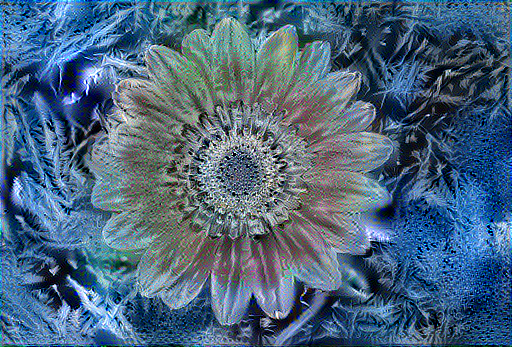

Epoch: 495
Total loss: 2.6146e+06, style loss: 1.0330e+06, content loss: 1.5816e+06, 


In [ ]:
best, best_loss,image = run_style_transfer(content_path,
                                     style_path, epochs=500)
